In [161]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Person 1

In [162]:
# constants
NUM_OF_BITS = 16
MAX_VALUE = 1 << NUM_OF_BITS - 1
PLAINTEXT_NUM = 10000
FULL_ENCRYPTION_ROUNDS = 4 # NOTE: round 5 is simply key mixing

# variables
round_keys = [55382, 42954, 53122, 38368, 40273]

s_box = {
    0x0: 0xb,
    0x1: 0x7,
    0x2: 0x5,
    0x3: 0xf,
    0x4: 0x8,
    0x5: 0x9,
    0x6: 0x1,
    0x7: 0xe,
    0x8: 0x4,
    0x9: 0xa,
    0xa: 0x6,
    0xb: 0xd,
    0xc: 0x2,
    0xd: 0xc,
    0xe: 0x0,
    0xf: 0x3,
}

def permutation(bit_str_16: str) -> str:
    assert(len(bit_str_16) == NUM_OF_BITS)
    res = list(bit_str_16)
    for i in range(0, NUM_OF_BITS):
        # print(4 * (i % 4) + (i // 4)) # debug
        res[4 * (i % 4) + (i // 4)] = bit_str_16[i]
    # print(bit_str_16) # debug
    # print(''.join(res)) # debug
    return ''.join(res)

def encrypt_one_round(to_encrypt: int, k: int) -> str:
    # key mixing
    # print(to_encrypt, k) # debug
    to_encrypt ^= k
    # print(to_encrypt) # debug

    # 4-bit s-box
    PART_NUM_OF_BITS = 4
    NUM_OF_PARTS = NUM_OF_BITS / PART_NUM_OF_BITS
    parts = [] # index 0: least significant
    while to_encrypt > 0:
        parts.append(to_encrypt % (1 << PART_NUM_OF_BITS))
        to_encrypt //= 16
    while len(parts) < 4:
        parts.append(0)
    assert(len(parts) == NUM_OF_PARTS)
    parts.reverse()
    # print("before s-box:", parts) # debug
    for i in range(0, len(parts)):
        parts[i] = s_box[parts[i]]
    # print("after s-box:", parts) # debug
    bit_str_16 = ''.join(f"{x:0{PART_NUM_OF_BITS}b}" for x in parts)
    # print(bit_str_16) # debug
    
    # permutation
    res = permutation(bit_str_16)
    # print(res) # debug
    return res

def full_encrypt(plaintext: int) -> int:
    # print(plaintext, f"{plaintext:0{NUM_OF_BITS}b}") # debug
    tmp = plaintext
    for i in range(0, FULL_ENCRYPTION_ROUNDS):
        tmp = int(encrypt_one_round(tmp, round_keys[i]), 2)
        # print(f"Round {i + 1}:") # debug
        # print(tmp, f"{tmp:0{NUM_OF_BITS}b}") # debug
    # last round: simple key mixing
    tmp ^= round_keys[FULL_ENCRYPTION_ROUNDS]
    # print(tmp, f"{tmp:0{NUM_OF_BITS}b}") # debug
    return tmp

In [163]:
# generate plaintext-ciphertext pairs
pc_paris = dict()
while len(pc_paris) < PLAINTEXT_NUM:
    plaintext = random.randint(0, MAX_VALUE)
    if plaintext in pc_paris.keys():
        continue
    pc_paris[plaintext] = full_encrypt(plaintext)
    # TODO: satisfy the chosen plaintext attack requirements
assert(len(pc_paris) == PLAINTEXT_NUM)
# print(pc_paris)

# Person 2

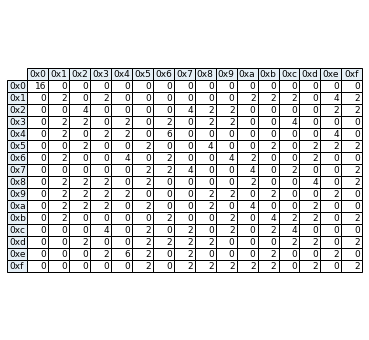

In [164]:
# compute s-box difference distribution table (Table 7)
from wsgiref import headers
from matplotlib.pyplot import table


diff_dist_table = [[0 for i in range(0, 16)] for j in range(0, 16)] # dimension 1: input diff; dimension 2: output diff
# print(diff_dist_table)
for x1 in range(0, 16):
    for x2 in range(0, 16):
        delta_x = x1 ^ x2
        # print(f"x1 = {x1}, x2 = {x2}, delta_x = {delta_x}")
        y1 = s_box[x1]
        y2 = s_box[x2]
        delta_y = y1 ^ y2
        # print(f"y1 = {y1}, y2 = {y2}, delta_y = {delta_y}\n")
        diff_dist_table[delta_x][delta_y] += 1
        # print(diff_dist_table)

headers=[hex(i) for i in range(0, 16)]
plt.figure(linewidth=2,
           figsize=(6, 6))
ax = plt.gca()
ax.axis("off")

rcolors = plt.cm.BuPu(np.full(len(headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(headers), 0.1))
table = plt.table(cellText=diff_dist_table,
                  rowLabels=headers,
                  rowColours=rcolors,
                  colLabels=headers,
                  colColours=rcolors,
                  loc="center")